## Bài toán phân loại sử dụng SVM 

Mục tiêu: 

- Xây dựng được mô hình svm sử dụng thư viện sklearn. 
- Ứng dụng, hiểu cách áp dụng mô hình svm vào giải quyết bài toán thực tế (vd: phân loại văn bản) 
- Sử dụng độ đo Accuracy để làm độ đo đánh giá chất lượng mô hình. 

Vấn đề: 
- Có một tập các văn bản dạng text không có nhãn, làm sao để biết văn bản này là thuộc về thể loại nào, pháp luật, đời sống, văn học, thể thao ...
- => Xây dựng mô hình học máy có thể phân loại các thể loại của văn bản chỉ dựa trên nội dung.  

Dữ liệu: 
- Có tập các văn bản và nhãn tương ứng của từng văn bản trong một khoảng thời gian 
- Tập các nhãn - 10 nhãn văn bản: 
    > Giải trí, Khoa học - Công nghệ, Kinh tế, Pháp luật, Sức khỏe, Thể thao, Thời sự, Tin khác, Độc giả, Đời sống - Xã hội
- Ví dụ văn bản nhãn **thể thao**: 
    > "Dân_trí Real Madrid đã dẫn trước trong cả trận đấu , nhưng họ vẫn phải chấp_nhận bị Dortmund cầm hòa 2-2 ở Bernabeu . Real Madrid chấp_nhận đứng thứ_hai ở bảng F Champions League ..."

Bài toán: 
- Input: tập các từ trong văn bản 1 mẫu dữ liệu $X = [x_1, x_2, ... x_n]$
- Output: nhãn $y$ là 1 trong 10 nhãn trên 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.datasets.base import load_files
from pyvi import ViTokenizer
from sklearn import svm
from sklearn.datasets.base import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

%matplotlib inline

/home/vutrungnghia/miniconda3/envs/svm/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


## 1. Load dữ liệu từ thư mục đã crappy từ trước 

Cấu trúc thư mục như sau 

- data/news_1135/

    - Kinh tế: 
        - bài báo 1.txt 
        - bài báo 2.txt 
    - Pháp luật
        - bài báo 3.txt 
        - bài báo 4.txt 

In [2]:
DATA_PATH = "data/news_1135/"
header = "%-20s%-30s" % ("Số lượng văn bản", "Nhãn")
print(header)
print("---------------------------------------------")
total = 0
for label in os.listdir(DATA_PATH):
    n = len(os.listdir(os.path.join(DATA_PATH, label)))
    total += n
    entry = "%-20d%-30s" % (n, label)
    print(entry)
print("---------------------------------------------")
print(f'Tổng số văn bản: {total}')

Số lượng văn bản    Nhãn                          
---------------------------------------------
107                 Giải trí                    
196                 Khoa học - Công nghệ      
186                 Kinh tế                     
50                  Pháp luật                  
75                  Sức khỏe                   
140                 Thể thao                    
138                 Thời sự                   
100                 Tin khác                     
91                  Đời sống - Xã hội      
52                  Độc giả                    
---------------------------------------------
Tổng số văn bản: 1135


In [3]:
data_train = load_files(container_path=DATA_PATH, encoding="utf-8")
print(dir(data_train))

['DESCR', 'data', 'filenames', 'target', 'target_names']


In [4]:
header = "%-6s %-10s" % ("ID", "Nhãn")
print(header)
print("---------------------------------------------")
for id, label in enumerate(data_train.target_names):
    print("%-6d %-10s" % (id, label))

ID     Nhãn      
---------------------------------------------
0      Giải trí
1      Khoa học - Công nghệ
2      Kinh tế 
3      Pháp luật
4      Sức khỏe
5      Thể thao
6      Thời sự
7      Tin khác 
8      Đời sống - Xã hội
9      Độc giả


In [5]:
print(data_train.data[0:2], end='\n\n')
print(data_train.filenames[0:2], end='\n\n')
print(data_train.target[0:2], end='\n\n')

['Dân_trí Sở GD & ĐT tỉnh Gia_Lai vừa ra văn_bản số 2258 / SGDĐT - VP , về việc chấn_chỉnh việc tiếp_thị sách và các vật_dụng khác trong các cơ_sở giáo_dục . Văn_bản chỉ_đạo , tuyệt_đối không cho phép các cá_nhân , tập_thể đến trường tiếp_thị , quảng_cáo mua_bán sách , dụng_cụ học_tập … cho giáo_viên và học_sinh trong nhà_trường . Các tổ_chức , cá_nhân trong ngành giáo_dục tuyệt_đối không được thực_hiện hoặc tham_gia giới_thiệu , quảng_bá , vận_động mua , phát_hành sách tham_khảo tới học_sinh hoặc phụ_huynh dưới hình_thức nào . Nhà_trường tuyệt_đối không được lưu_hành , sử_dụng sách có nội_dung không lành_mạnh , không phù_hợp với nội_dung chương_trình phổ_thông . Trường_hợp phát_hiện sách có sai_sót , các đơn_vị cần báo_cáo với cấp trên để có hướng xử_lý . Các sơ sở giáo_dục đề_cao cảnh_giác đối_với trường_hợp mạo_danh cán_bộ , chuyên_viên sở trong ngành đi giới_thiệu sách , đồ_dùng học_sinh ; công_khai phổ_biến các quy_định trên đến cán_bộ , giáo_viên , học_sinh để cùng phòng tránh và

In [23]:
"""Bài tập
 - Kiểm tra các thông tin sau:
    + Số lượng văn bản trong data_train.data
    + Số lượng ids trong data_train.target
    + Số lượng filenames trong data_train.filenames
"""
###############
###############

1135
1135
1135


###  Tiền xử lý dữ liệu đưa dữ liệu từ dạng text về dạng ma trận bằng TF-IDF

- Thử nghiệm để kiểm tra hoạt động chuyển hoá dữ liệu về dạng ma trận 

In [7]:
# load dữ liệu các stopwords 
with open("data/vietnamese-stopwords.txt") as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords]
print(f"Tổng số lượng từ dừng: {len(stopwords)}")
print("Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại): ", stopwords[:10])
print()

"""
Chuyển hoá dữ liệu text về dạng vector tfidf 
    - loại bỏ từ dừng
    - sinh từ điển
    - chuyển thành dữ liệu dạng ma trận 2 chiều kích thước n x m với n là số lượng văn bản và m là số lượng từ trong từ điển
"""
module_count_vector = CountVectorizer(stop_words=stopwords)
model_rf_preprocess = Pipeline([('vect', module_count_vector),
                    ('tfidf', TfidfTransformer()),
                    ])
data_preprocessed = model_rf_preprocess.fit_transform(data_train.data, data_train.target)
print("5 từ đầu tiên trong từ điển:\n")
i = 0
for k,v in module_count_vector.vocabulary_.items():
    i+=1
    print(i, ": ", (k, v))
    if i > 5:
        break 
print()

# Số chiều của dữ liệu 
print(f"Số chiều của dữ liệu: {data_preprocessed.shape}")
print(f"Số từ trong từ điển: {len(module_count_vector.vocabulary_)}")

Tổng số lượng từ dừng: 2063
Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại):  ['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']

5 từ đầu tiên trong từ điển:

1 :  ('dân_trí', 6928)
2 :  ('sở', 17869)
3 :  ('gd', 7729)
4 :  ('đt', 23214)
5 :  ('tỉnh', 20851)
6 :  ('gia_lai', 7816)

Số chiều của dữ liệu: (1135, 24389)
Số từ trong từ điển: 24389


### Chia dữ liệu thành 2 phần train_data và test_data
- train_data chiếm 80 % dữ liệu 
- test_data chiếm 20 % dữ liệu 

In [8]:
from sklearn.model_selection import ShuffleSplit

# chia dữ liệu thành 2 phần sử dụng hàm train_test_split.
test_size = 0.2
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split( data_preprocessed, data_train.target, test_size=test_size)


# hiển thị một số thông tin về dữ liệu 
print("Dữ liệu training = ", X_train.shape, y_train.shape)
print("Dữ liệu testing = ", X_test.shape, y_test.shape)

Dữ liệu training =  (908, 24389) (908,)
Dữ liệu testing =  (227, 24389) (227,)


In [8]:
"""Bài tập
 - Hiển thị ra id, tên nhãn của 5 văn bản đầu tiên trong tập train. 
 - Gợi ý: lấy dữ liệu id từ biến y_train, mapping với thứ tự nằm trong mảng data_train.target_names
"""
###############
###############

4 Sức khỏe
6 Thời sự
5 Thể thao
6 Thời sự
4 Sức khỏe


## 2. Huấn luyện mô hình SVM trên tập train_data

Sử dụng thư viện sklearn để xây dựng mô hình 
- `svm.SVC(kernel='linear', C=1.0)`: chọn hàm nhân phân tách là linear, tham số C=1.0 

In [9]:
print("- Training ...")


# X_train.shape
print("- Train size = {}".format(X_train.shape))
model = svm.SVC(kernel='linear', C=1.0)
model.fit(X_train, y_train)

print("- model - train complete")


- Training ...
- Train size = (908, 24389)
- model - train complete


## 3. Đánh giá mô hình SVM trên tập test_data

Thực hiện dự đoán nhãn cho từng văn bản trong tập test 

Độ đo đánh giá: 
> accuracy = tổng số văn bản dự đoán đúng  / tổng số văn bản có trong tập test  

In [10]:
from sklearn.metrics import accuracy_score
print("- Testing ...")
y_pred = model.predict(X_test)
print("- Acc = {}".format(accuracy_score(y_test, y_pred)))


- Testing ...
- Acc = 0.8414096916299559


### 3.1. Thực hiện sử dụng model đã được train để suy diễn 1 văn bản mới 
- Dữ liệu mới đến ở dạng dữ liệu thô => cần tiền xử lý dữ liệu về dạng dữ_liệu_ma_trận
- infer sử dụng hàm model.predict(dữ_liệu_ma_trận) 

In [11]:
# tiền xử lý dữ liệu sử dụng module model_rf_preprocess. 
news = ["Công_phượng ghi bàn cho đội_tuyển Việt_nam"]
preprocessed_news = model_rf_preprocess.transform(news)
print(preprocessed_news, end='\n\n')
pred = model.predict(preprocessed_news)
print(pred, data_train.target_names[pred[0]])

  (0, 24149)	0.6411817745645509
  (0, 21498)	0.327365802861761
  (0, 7776)	0.4797308142038527
  (0, 3408)	0.5015734332939062

[5] Thể thao


## 4. Bài tập bổ sung: 

### 4.1 Thử nghiệm các tham số 

- Các tham số với giá trị khác nhau có thể ảnh hưởng để kết quả học 
- Cần thử nghiệm kỹ lượng để đưa ra kết quả khách quan: tham số C, kernel.
    - Chọn mô hình với bộ tham số cho kết quả tốt nhất 

In [38]:
"""Bài tập
 - Đánh giá các tham số của mô hình SVM: kernel, C
 - Gợi ý:
     + Đầu tiên cố định C = 1.0 (có thể là giá trị khác), thay đổi kernel = {'linear', 'poly', 'rbf', 'sigmoid'}
     + Với mỗi kernel chạy huấn luyện và đánh giá lại mô hình. Chọn kernel cho acc cao nhất.
       Giả sử trong trường hợp này là linear
     + Cố định kernel là linear, thay đổi C = {0.1, 1.0, 5.0, 10.0}
     + Với mỗi giá trị C chạy huấn luện và đánh giá lại. Chọn C cho acc cao nhất.
"""
######################

######################

### 4.2 Phân loại số viết tay

Dữ liệu training =  (1437, 64) (1437,)
Dữ liệu testing =  (360, 64) (360,)


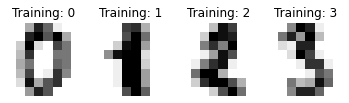

In [12]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
target = digits.target
X_train, X_test, y_train, y_test = train_test_split( data, target, test_size=test_size)

print("Dữ liệu training = ", X_train.shape, y_train.shape)
print("Dữ liệu testing = ", X_test.shape, y_test.shape)

In [ ]:
"""Bài tập
 - Đánh giá các tham số của mô hình SVM với bài toán phân loại ảnh
 - Gợi ý: Làm tương tự với phân loại văn bản phía trên
"""
######################

######################